<a href="https://colab.research.google.com/github/aquapathos/BasicAI/blob/master/5CNN/CIFAR10PyTorch003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


CIFAR10PyTorch001, CIFAR10PyTorch002 が完了していることを前提としています。まだの人は先に済ませてください。

# 1. 準備
## 1.1 ハードウェアアクセラレータの設定

1. 「CIFAR10PyTorch001, CIFAR10PyTorch002」を済ませておく
2. [「ランタイム」メニューを開く]()
3. [「ランタイムのタイプを変更」をクリック]()
4. [[「ハードウェアアクセラレータ」で **GPU** を選択し，「保存」]()

<font color='green'>※ Google Colabは無料サービスを維持するため、利用者が多すぎるため GPU が使えない場合があります。その場合は時間がかかりますが、CPUでも実験は可能です。    
※ 同様に、複数セッションが許可されない場合があります。「セッションが多すぎます」と出た場合は他の起動中ランタイムを終了させてください。</font>

[次のセルを実行してください]() 　コードは非表示にしてあります。

In [ ]:
#@title 動作環境の確認
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
if device.type != 'cpu':
  print(torch.cuda.get_device_name())
  print(torch.cuda.get_device_capability())
  N_MID=64
else:
  N_MID=32

cuda:0
Tesla T4
(7, 5)


## 1.2  Google Drive をマウント
AIChallenge001 で保存した画像データを使うために Google Drive に接続します。

1. <font color='blue'>この説明の下のセルを実行する
2. アクセス許可の確認ダイアログが出る。「Googleドライブに接続」をクリック。
3. アカウントを選択する。
4. アクセスリクエストのダイアログに変わる。一番下までスクロールし「許可」をクリック。
5. 左のファイル一覧エリアで「更新アイコン」（回転マーク）をクリック（エリアが表示されていないなら「ファイルアイコン」（フォルダ型）をクリック）
6. しばらく待つと drive という名のフォルダが現れます。</font>

<img width="390" alt="googlecolab" src="https://user-images.githubusercontent.com/5820803/94802343-739cff00-0422-11eb-8c0d-affa919f8e58.png">


　[次のセルを実行してください]() 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.3 表示用ヘルパー関数の定義
002 で定義したのと同じ関数を読み込みます。　[次のセルを実行してください]() （コードは非表示にしてありますが実行できます。興味があるなら表示しても構いません。）



In [ ]:
#@title
!pip -q install japanize-matplotlib
import pickle
import os,math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib
from pandas.compat.numpy import np_datetime64_compat

# pickle 形式で保存された画像データの読み込み
def loadCategoryImages(fname, folder = "."):
    f = open(folder+"/"+fname,'rb')
    cat = pickle.load(f)
    f.close
    return cat

# start番からnpic枚表示する関数を定義
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 7.0)
def showimg(images, start = 0, npic = 48):
    n = npic if len(images) >= start+npic else len(images) - start
    plt.figure(figsize=(8,7.5*(math.ceil(n/8))/6),dpi=150)
    i = 0
    while True:
        if i < n :  
            plt.subplot((n-1)//8+1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[start+i])
            plt.title("{}".format(start+i))
            i += 1
        else:
            break

     |████████████████████████████████| 4.1 MB 43.2 MB/s 


# 2 独自データセットの作成
## 2.1 画像データの復元


# Google Drive からの画像の読み出し

002で集めた画像を読み込みましょう。  
<font color= blue>
次のセルの **myclasses = ['ネコ','イヌ','灯台','スクータ']**  を自分の選んだカテゴリに書き換えてから実行してください。</font>

<img width="234" alt="yourimages" src="https://user-images.githubusercontent.com/5820803/184477244-df5ded39-9474-408c-93c1-774b846456d0.png">


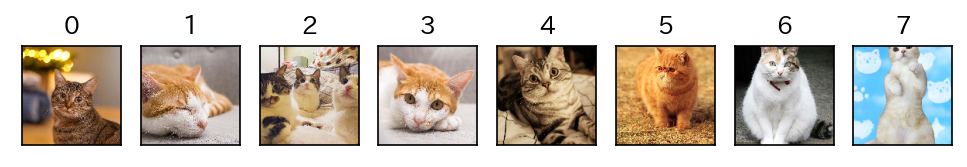

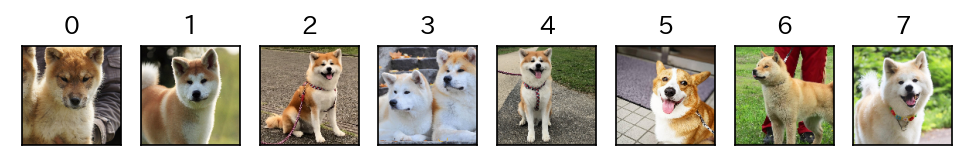

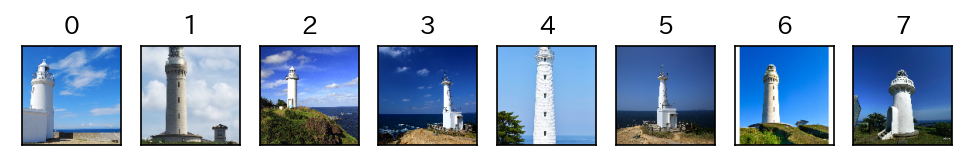

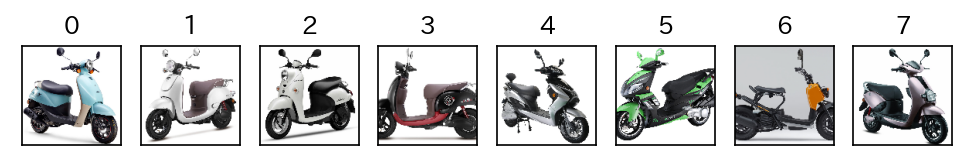

In [ ]:
myclasses = ['ネコ','イヌ','灯台','スクータ']
GFOLDER = "drive/MyDrive/CIFAR10"  # データ保存用のフォルダ名
myimages = {'classes':myclasses}
for c in myclasses:
  myimages[c] = loadCategoryImages(f"{c}.pkl", folder=GFOLDER)
  showimg(myimages[c],0,8)

## 2.2 自分で集めた画像でデータセットを作成する

自分で収集した画像を使って次の３つのデータセットを作ります。

1. **trainset**   訓練用データセット
2. **testset**    テスト用データセット
3. **catset**     ネコ画像のみからなるデータセット

- 画像の枚数は一番枚数の少ないカテゴリに合わせることにします。
- 画像全体の3分の2を使って訓練用、残りでテスト用のデータセットを作成します。
- 訓練用とテスト用のデータセットは、各カテゴリが均等に含まれるようにします。

　[次のセルを実行してください]() 　コードは非表示にしてあります。


In [ ]:
#@title　データセットの作成
# ライブラリのインポート
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import os

#  自分で集めた画像データで訓練用とテスト用に分割する
def make_datasetdata(myimages):
    # catlist で与えられた画像データのリストから訓練用とテスト用のデータを作成し，
    # Xtrain (訓練用画像), ytrain（訓練例の正解)，Xtrain (テスト用画像), ytrain（テスト画像に対する)，NDATA（1カテゴリ当たりのデータ数）
    # 学習に用いるデータ数を、一番データ数の少ないカテゴリのデータ数に合わせる
    classes = myimages['classes']
    mindata = np.inf # 十分大きな数
    for c in classes:
        if len(myimages[c]) < mindata:
            mindata = len(myimages[c])
    # ここに到達した時点で、mindata にはもっともデータ数の少ないカテゴリのデータ数が入っている
    NDATA = mindata
    threer = mindata%3
    NDATA = mindata - threer  #  個数を３の倍数となるよう調整

    Xtrain,Xtest = [],[]  # 入力画像のリスト
    ytrain,ytest = [],[]  #  ラベルのリスト
    label = 0
    for c in classes:
        Xtrain = Xtrain + myimages[c][0:int(2*NDATA/3)]
        ytrain = ytrain + [label]*int(2*NDATA/3)
        Xtest = Xtest + myimages[c][int(2*NDATA/3):NDATA]
        ytest = ytest + [label]*int(NDATA/3)
        label +=1
    return np.array(Xtrain),np.array(ytrain),np.array(Xtest),np.array(ytest),NDATA

Xtrain,ytrain,Xtest,ytest,NDATA = make_datasetdata(myimages=myimages)
print(f'訓練用計{len(ytrain)}枚,テスト用計{len(ytest)}枚')

# データ変換の定義　範囲[-1,+1]のテンソル表現への変換
transforms0 =  transforms.Compose(  # 正規化のみ
    [transforms.ToTensor(),transforms.Resize((32,32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transforms1 = transforms.Compose(   # アフィン変換＋色調変換＋ランダムな左右反転による画像水増し
    [
     transforms.ToTensor(),
     transforms.RandomAffine(degrees=[-5, 5], translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
     transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
# 独自データセットのクラス定義
class MyDataset(Dataset):
    def __init__(self, data,labels, transforms):
        super().__init__()
        self.transforms = transforms
        self.data = data
        self.labels = labels

    def __getitem__(self,index: int):
        data = self.data[index]
        label = self.labels[index]
        # データの変形 (transforms)
        data = self.transforms(data)
        return data, label

    def __len__(self) -> int:
        return len(self.data)

trainset = MyDataset(Xtrain,ytrain,transforms0)
# trainset1 = MyDataset(Xtrain,ytrain,transforms1)
testset = MyDataset(Xtest,ytest,transforms0)
Xallset = np.concatenate([Xtrain,Xtest])
yallset = np.concatenate([ytrain,ytest])
allset = MyDataset(Xallset,yallset,transforms0)
catindex = (yallset == myclasses.index('ネコ'))
catset = MyDataset(Xallset[catindex],yallset[catindex],transforms0)


## 2.3 データローダの作成
上で作成したデータセットで、次の３つのデータローダを作成します。
1. trainloader    訓練用画像を枚挙するデータローダ
2. testloader     テスト用画像を枚挙するデータローダ
3. catloader      ネコ画像ばかりを枚挙するデータローダ

　[次のセルを実行してください]()  　コードは非表示にしてあります。

In [ ]:
#@title　データローダの作成
BATCH_SIZE = 8 # バッチサイズ　データ数いくつごとにモデル修正するか
WORKERS = 2 # 並列処理するときの並列実行の数

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=WORKERS)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=WORKERS)
catloader = DataLoader(catset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=WORKERS)

### データローダの動作確認

　[次のセルを実行してください]() 　コードは非表示にしてあります。

In [ ]:
#@title　データローダの動作確認
# 画像を１枚表示する関数
def t2np(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# データローダからバッチ数分の画像を取り出す。
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 先頭の画像を表示
plt.imshow(t2np(images[0]))

# １バッチ分の画像を並べて表示
cifar10classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 仮
def plotchr(images,labels,tlabels=[],classnames=cifar10classes):
    # sns.set_context("talk")   # "talk" はタイトルの文字サイズ。　paper <  notebook <  talk <  poster の順にフォントサイズが大きくなる
    low = (len(images)-1)//BATCH_SIZE+1
    for i,(image,label) in enumerate(zip(images,labels)):
        clabel = classnames[label]
        image = t2np(image)
        plt.subplot(1,BATCH_SIZE,i+1)
        plt.xticks([])
        plt.yticks([])
        if len(tlabels) > 0:
          plt.title(f"{clabel}/{classnames[tlabels[i]]}") 
        else:
          plt.title("%s" % clabel) 
        plt.imshow(image,cmap=plt.cm.gray_r)

plt.figure(figsize=(10,4),dpi=100)
plotchr(images,labels,tlabels=[],classnames=myclasses)

## 2.4 CIFAR10用学習済みモデルで自分の画像データを識別させてみる
### (1) モデルの読み込み

<font color=red> (注意) ここから後はCIFAR10PyTorch001で作成した学習済みモデルが必要となります。

自分のグーグルドライブを開き、マイドライブのCIFAR10 フォルダに cpu_64_model3.pthと gpu_64_model3.pth があるかどうか確認してください。ない場合は、Caddie に添付されているファイルをアップロードしてから実験を進めてください。

GPUが使える場合　→ gpu_64_model3.pth  
GPUが使えない場合→ cpu_64_model3.pth

</font>



[次のセルを実行してください]() 　コードは非表示にしてあります。



In [ ]:
#@title Model3 のクラス定義と学習済みモデル model3 の復元
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"   # device side error が出る場合があるので同期を有効にしてみる。

# Model3 定義
class FReLU(nn.Module):
    def __init__(self, in_c, k=3, s=1, p=1):
        super().__init__()
        self.f_conv = nn.Conv2d(in_c, in_c, kernel_size=k,stride=s, padding=p,groups=in_c)
        self.bn = nn.BatchNorm2d(in_c)

    def forward(self, x):
        tx = self.bn(self.f_conv(x))
        out = torch.max(x,tx)
        return out

class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_mid = N_MID
        self.conv1 = nn.Conv2d(3,6, 3,padding=1, padding_mode='replicate') 
        self.frelu = FReLU(6)
        self.conv2 = nn.Conv2d(6,16,3, padding=1,padding_mode='replicate')
        self.frelu1 = FReLU(16)
        self.pool = nn.MaxPool2d(2)  
        self.conv3  = nn.Conv2d(16, self.n_mid, 3, padding=1,padding_mode='replicate')
        self.frelu2 = FReLU(self.n_mid)
        self.conv4  = nn.Conv2d(self.n_mid, self.n_mid, 3,padding=1, padding_mode='replicate')  
        self.frelu3 = FReLU(self.n_mid)    
        self.gavg = nn.AvgPool2d(8) # グローバルアベレージプーリング 
        self.layer = nn.Linear(self.n_mid, 10) 

    def forward(self, x):
        x = self.conv1(x) # 3ch -> 6  3x3フィルタで畳み込み 32x32->32x32
        x = self.frelu(x)
        x = self.conv2(x) # 6ch -> 16  3x3フィルタで畳み込み 32x32 -> 32x32
        x = self.frelu1(x)        
        x = self.pool(x)  # max pooling  2x2  32x32->16x16
        x = self.conv3(x) # 16ch -> n_mid ch 3x3フィルタで畳み込み 16x16 -> 16x16
        x = self.frelu2(x) 
        x = self.conv4(x) # n_mid ch -> n_mid ch 3x3フィルタで畳み込み 16x16 -> 16x16
        x = self.frelu3(x)
        x = self.pool(x)  # max pooling  2x2  16x16->8x8
        x = self.gavg(x)  # n_midノード
        x = x.view(-1,self.n_mid)
        x = self.layer(x) # n_mid->10
        return x

model3 = Model3()
model3.to(device)

# 学習済みモデルの重みのセット
FNAME = 'model3.pth'
DIR = '/content/drive/MyDrive/CIFAR10'  
GPUPATH = f"{DIR}/gpu_{N_MID}_{FNAME}"
CPUPATH = f"{DIR}/cpu_{N_MID}_{FNAME}"
if device.type == 'cuda':
    model3.load_state_dict(torch.load(GPUPATH))
else:
    model3.load_state_dict(torch.load(CPUPATH,map_location=torch.device('cpu')))

summary(model3,(3,32,32))

import copy
backupmodel = copy.deepcopy(model3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
            Conv2d-2            [-1, 6, 32, 32]              60
       BatchNorm2d-3            [-1, 6, 32, 32]              12
             FReLU-4            [-1, 6, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             880
            Conv2d-6           [-1, 16, 32, 32]             160
       BatchNorm2d-7           [-1, 16, 32, 32]              32
             FReLU-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]           9,280
           Conv2d-11           [-1, 64, 16, 16]             640
      BatchNorm2d-12           [-1, 64, 16, 16]             128
            FReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

### (2) CIFAR10のモデルに識別させてみる
ためしに、CIFAR10のデータセットで学習させたモデルで自作データセットの認識をさせてみましょう。

ネコ画像だけで作成したデータセットのネコ画像を正しくネコと認識できる割合を求めてみます。

　[次の２つのセルを続けて実行してください]() 

In [ ]:
#@title　ネコの正解率
ncat = 0 # ネコと判定されたデータのカウンタ
ndata = 0 # データのカウンタ
model3.eval() # 推論モードにスイッチ
for data in catloader:
  images, labels = data
  ndata += len(images)
  images = images.to(device)
  outputs = (torch.max(model3(images),1)[1]).to('cpu').numpy()
  ncat += (outputs == cifar10classes.index('cat')).sum()
print(f"cat 正解率 {100*ncat/ndata:.1f}% ,({ncat}/{ndata})")

cat 正解率 19.0% ,(36/189)


In [ ]:
#@title　識別結果の例　実行するたびに別の結果が表示されます
dataiter = iter(catloader)  # 全部ネコ画像のはず
plt.figure(figsize=(10,3),dpi=100)
images, labels = dataiter.next()
images = images.to(device)
outputs = model3(images)
predicted = torch.max(outputs.data, 1)[1]
images = images.to('cpu') if torch.cuda.is_available() else images
plotchr(images,predicted,[])

例として８つだけ画像を表示しています。画像の上のラベルはmodel3 の識別結果です。

ネコはCIFAR10のカテゴリの中では正解率が相対的に低くなる傾向があります。自分で集めたネコ画像だと正解率はさらに低く出たと思います。検索で集めた画像はネコが中央に大きく写っているとは限らないので正解率が低くなるのは仕方ありません。

ネコ以外の画像だとどう認識されるかも試してみましょう。trainloaderがランダムに選んだ8枚で試してみます。もちろん、CIFAR10のカテゴリのいずれかとして認識されてしまいます。

　[次のセルを実行してください]() 　　コードは非表示にしてあります。

In [ ]:
#@title 集めた画像をランダムに識別　何度か繰り返し実行してみましょう
dataiter = iter(trainloader)  #
plt.figure(figsize=(10,3),dpi=100)
images, labels = dataiter.next()
images = images.to(device)
outputs = model3(images)
predicted = torch.max(outputs.data, 1)[1]
images = images.to('cpu') if torch.cuda.is_available() else images
plotchr(images,predicted,[])

[上のセルは実行するたびに異なる画像が出てきます。何度か試してみてください。]()

# ３．自作データセットでのモデルの学習

## 3.1 学習用ヘルパー関数の定義

　[次のセルを実行してください]() 　コードは非表示にしてあります。

In [ ]:
#@title　学習用ヘルパー関数
# 学習用ヘルパー関数
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./logs")

def train(model, dataloader, optimizer, epochs=1,lastepoch=0,label="loss"):
    model.train() # 学習モードにスイッチ
    for epoch in range(lastepoch,epochs,1):  # 全データをEPOCH回学習に利用したら終わり
        running_loss = 0.0
        accuracy = 0
        total = 0
        nbatch = len(dataloader.dataset)//BATCH_SIZE
        ndata = len(dataloader.dataset)
        for i, data in enumerate(dataloader, 0):
            # データセットからバッチサイズ個分のデータ[inputs, labels]を取り出す。
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # すべての学習対象パラメータ（結合重み、しきい値）の微係数を０にセット
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images) # 現モデルを使って出力を求める (forward)
            predicted = torch.max(model(images),1)[1]
            loss = nn.CrossEntropyLoss()(outputs, labels) #  # カテゴリカルクロスエントロピー誤差を計算
            loss.backward() # パラメータを変数として誤差を偏微分(backward)
            optimizer.step() # 誤差逆伝搬学習　誤差が減る方向にパラメータを修正 (optimize) 

            # 統計量の出力 epoch 毎に表示
            running_loss += loss.item()
            accuracy += (predicted == labels).sum().item() # 正解数を積算
            total += labels.size(0) # 入力画像数を積算
            if i in[nbatch//4-1,nbatch//2-1,3*nbatch/4-1,nbatch-1]:
                writer.add_scalar(label+"loss", running_loss/total,epoch*ndata+total)
                writer.add_scalar(label+"acc", accuracy/total,epoch*ndata+total)
        
        print(f'[{epoch + 1}] loss: {running_loss /total:.3f}  acc:{accuracy/total:.3f}  ({accuracy}/{total})')


    print('学習完了')

# 結果分析用ヘルパー関数
from pandas.compat.numpy import np_datetime64_compat
import pandas as pd
# クロス集計
def recognitionResult(model, dataloader, classes=[]):
    model.eval() # 推論モードにスイッチ
    ndata = 0 #
    NCAT = len(classes) 
    ct1 = np.zeros((NCAT,NCAT),np.uint16) # 認識結果集計表
    for data in dataloader:
      images, labels = data
      ndata += len(images)
      # バッチごとに出力を求める
      images = images.to(device)
      outputs = torch.max(model(images),1)[1]
      for i in range(len(labels)):
        ct1[labels[i],outputs[i]] += 1
    crossT1 = pd.concat([pd.DataFrame(classes,columns=['正解カテゴリ']),pd.DataFrame(ct1,columns=classes)],axis=1)
    crossT1 = pd.concat([crossT1,pd.DataFrame([np.nan if sum(ct1[i])==0 else np.round(1000*crossT1[cat][i]/np.sum(ct1[i]))/10 for i,cat in enumerate(classes)],columns=['正解率'])],axis=1).set_index('正解カテゴリ')
    
    ccount = 0
    for i in range(len(classes)):
      ccount += ct1[i,i]
    print(f"正解率は{np.round(1000*ccount/ct1.sum())/10}%")
    return crossT1

## 3.2 モデル定義
CIFAR10で定義した Model3 の出力だけを４つにしたモデル、Model4 を定義します。
[次のセルを実行してください]()  


In [ ]:
#@title
class Model4(Model3):
  def __init__(self):
    super().__init__()
    self.layer = nn.Linear(self.n_mid, 4)   # この部分の出力だけを10から4に変える

    def forward(self, x):
        x = self.conv1(x) # 3ch -> 6  3x3フィルタで畳み込み 32x32->32x32
        x = self.frelu(x)
        x = self.conv2(x) # 6ch -> 16  3x3フィルタで畳み込み 32x32 -> 32x32
        x = self.frelu1(x)        
        x = self.pool(x)  # max pooling  2x2  32x32->16x16
        x = self.conv3(x) # 16ch -> n_mid ch 3x3フィルタで畳み込み 16x16 -> 16x16
        x = self.frelu2(x) 
        x = self.conv4(x) # n_mid ch -> n_mid ch 3x3フィルタで畳み込み 16x16 -> 16x16
        x = self.frelu3(x)
        x = self.pool(x)  # max pooling  2x2  16x16->8x8
        x = self.gavg(x)  # n_midノード
        x = x.view(-1,self.n_mid)
        x = self.layer(x) # n_mid->10
        return x
    
model4 = Model4()
model4 = model4.to(device)

optimizer4 = optim.Adam(model4.parameters(), lr=0.001) # 

# モデル概要
summary(model4,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
            Conv2d-2            [-1, 6, 32, 32]              60
       BatchNorm2d-3            [-1, 6, 32, 32]              12
             FReLU-4            [-1, 6, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             880
            Conv2d-6           [-1, 16, 32, 32]             160
       BatchNorm2d-7           [-1, 16, 32, 32]              32
             FReLU-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]           9,280
           Conv2d-11           [-1, 64, 16, 16]             640
      BatchNorm2d-12           [-1, 64, 16, 16]             128
            FReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

Model3との違いは最終層の出力の数だけです。CIFAR-10では10カテゴリだったので最後hあ10ノードでしたが自分で集めが画像は4カテゴリなので４としています。

## 3.3 学習

 さっそく学習させてみましょう。  [次のセルを実行してください。]()

In [ ]:
%%time
EPOCH = 20
model4 = Model4()
model4 = model4.to(device)
optimizer4 = optim.Adam(model4.parameters(), lr=0.001) # 
train(model=model4, optimizer=optimizer4, dataloader=trainloader, epochs=EPOCH, lastepoch=0,label="model4")

CIFAR10のデータセットと比べてデータ数が圧倒的に少ないので学習はすぐ終わるはずです。

## 3.4 識別実験



 [セルを順に実行していってください。]()

In [ ]:
#@title　正解率
print("訓練画像 -- ",end='')
trainct = recognitionResult(model4,trainloader,classes=myclasses)
print("テスト画像 -- ",end='')
testct = recognitionResult(model4,testloader,classes=myclasses)
#trainct

訓練画像 -- 正解率は93.1%
テスト画像 -- 正解率は76.2%


In [ ]:
#@title 訓練用画像の識別結果のクロス集計 
trainct

In [ ]:
#@title テスト用画像の識別結果のクロス集計
testct

どんな画像を間違ったかいくつか見てみましょう。　次のセルを実行してください。

In [ ]:
#@title 誤識別例
n = 0
dataiter = iter(testloader)
errs = []
el = []
tl = []
while n < 8:
  images, labels = dataiter.next()
  images = images.to(device)
  outputs = model4(images)
  predicted = torch.max(outputs.data, 1)[1]
  for i,l in enumerate(labels):
    if l != predicted[i]:
      errs.append(images[i].to('cpu'))
      tl.append(l)
      el.append(predicted[i])
      n += 1
      img = np.transpose(images[i].to('cpu'),(1,2,0))
      img = (img+1)/2

plt.figure(figsize=(12,3),dpi=100)
plotchr(errs[:8],el[:8],tl[:8],myclasses)

上のセルを何度か実行してみましょう。間違いの傾向があるでしょうか？　間違った理由が創造できるでしょうか？

学習の様子をグラフで確認してみましょう。 [次のセルを実行してください]()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs

グラフを見ると、もっと学習すると正解率は上がりそうです。30エポック追加学習してみましょう。  
　[次のセルを実行してください]()

In [ ]:
train(model=model4, optimizer=optimizer4, dataloader=trainloader, epochs=50, lastepoch=20,label="model4")

正解率が向上したかどうか確認してみましょう。 [次のセルを実行してください]()

In [ ]:
#@title　追加学習後の正解率
print("訓練画像 -- ",end='')
trainct = recognitionResult(model4,trainloader,classes=myclasses)
print("テスト画像 -- ",end='')
testct = recognitionResult(model4,testloader,classes=myclasses)
#trainct

訓練画像 -- 正解率は99.8%
テスト画像 -- 正解率は75.8%


model4 は 50エポックぐらいで訓練画像についてはほぼ100％正解するようになります。

訓練画像は正解のわかっている画像なので、100％正解でも驚くに値しません。正解を丸覚えしてしまえば100％正解できるからです。深層学習は丸覚えではありませんが、100％正解というのは過学習を疑わないといけません。

# ４. 転移学習
## 4.1 モデルの流用

ある認識問題用に作られた学習済みモデルを他の認識問題に流用することを**転移学習**と呼びます。

同じモデル構造を使ったとしても、識別対象が変われば注目すべき特徴、取り出すべき特徴量は変わるはずですし、モデルの最適なパラメータが同じであるわけはありませんが、パラメータをランダムな初期値で始めて学習を進めるより、別の問題で成功したパラメータ値を初期値ととした方が効率的にパラメータの最適化ができることが経験的にわかっています。

これは、問題、つまり識別対象が違っても、中間層までで取り出すべき特徴は共通しているということを意味します。画像処理的に言えば、画像に基づいて何らかの判断を下すのであれば、問題に限らず初期段階で画像を加工して取り出すべき特徴は変わらない、ある問題で役に立った特徴や処理は別の問題でも有用だ、ということを意味しています。

CIFAR10PyTorch001で保存したModel３の学習済みモデルを使って転移学習を試みます。

　[次のセルを実行してください]() 


In [ ]:
#@title
# model3の最後の畳み込み層を除いてパラメータを固定する
for name, param in model3.named_parameters():
  if 'frelu3' in name or 'conv4' in name:
    param.requres_grad = True
    print(name)
  else:
    param.requres_grad = False
# model3 の改造　最終層を出力数４に置き換える。
model3.layer = (nn.Linear(N_MID,4)).to(device)  # 出力層を出力４の全結合層に置き換える。
from torchsummary import summary
summary(model3,(3,32,32))

conv4.weight
conv4.bias
frelu3.f_conv.weight
frelu3.f_conv.bias
frelu3.bn.weight
frelu3.bn.bias
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
            Conv2d-2            [-1, 6, 32, 32]              60
       BatchNorm2d-3            [-1, 6, 32, 32]              12
             FReLU-4            [-1, 6, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             880
            Conv2d-6           [-1, 16, 32, 32]             160
       BatchNorm2d-7           [-1, 16, 32, 32]              32
             FReLU-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]           9,280
           Conv2d-11           [-1, 64, 16, 16]             640
      BatchNorm2d-12           [-1, 64, 16, 16]             128
       

上のプログラムで、学習済みモデル model3 のパラメータを、最後の畳み込み層を除き、固定し、最後の層を出力数４の全結合層に置き換えています。

結果として学習の対象は最後の畳み込み層と出力層だけになります。

このモデルを自作データで学習させてみましょう。　　　[次のセルを実行してください]() 

In [ ]:
%%time
optimizer3 = optim.Adam(model3.parameters(), lr=0.001) # 
train(model=model3, optimizer=optimizer3, dataloader=trainloader, epochs=20, lastepoch=0,label="model3")

20エポック学習させただけで、ほぼ収束します。  [次のセルを実行してください]()

In [ ]:
trainct3 = recognitionResult(model3, trainloader,classes=myclasses)
testct3 =  recognitionResult(model3, testloader,classes=myclasses)

正解率は99.8%
正解率は82.9%


In [ ]:
trainct3

In [ ]:
testct3

In [ ]:
#@title mode3 転移モデルの誤識別例
n = 0
dataiter = iter(testloader)
errs = []
el = []
tl = []
while n < 8:
  images, labels = dataiter.next()
  images = images.to(device)
  outputs = model3(images)
  predicted = torch.max(outputs.data, 1)[1]
  for i,l in enumerate(labels):
    if l != predicted[i]:
      errs.append(images[i].to('cpu'))
      tl.append(l)
      el.append(predicted[i])
      n += 1
      img = np.transpose(images[i].to('cpu'),(1,2,0))
      img = (img+1)/2

plt.figure(figsize=(12,3),dpi=100)
plotchr(errs[:8],el[:8],tl[:8],myclasses)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs

# 課題

1. 結果について考察してください．（例えば，他のカテゴリと比べて正解が多いカテゴリや逆に間違いが多いカテゴリなど，気づいたことや，その理由など．）

余裕があれば次のような追加実験をしましょう．

2. 同じ実験を何度か繰り返し，同じ傾向がみられるかどうか検証する．
3. エポック数をもっと増やして正解率が上がるかどうか調べる。
4. 別のカテゴリで実験してみる。
5. もっとカテゴリを増やして実験してみる．
